# Image Classification and Object Localization

In this lab, you'll build a CNN from scratch to:
- classify the main subject in an image
- localize it by drawing bounding boxes around it.

You'll use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset to synthesize a custom dataset for the task:
- Place each "digit" image on a black canvas of width 75 x 75 at random locations.
- Calculate the corresponding bounding boxes for those "digits".

The bounding box prediction can be modelled as a "regression" task, which means that the model will predict a numeric value (as opposed to a category).

## Imports

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.10.0


# Visualization Utilities

These functions are used to draw bounding boxes around the digits.

In [3]:
#@title Plot Utilities for Bounding Boxes [RUN ME]

im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
    """ Draws bounding boxes on image (numpy array).
    Args:
        image: 
            a numpy array object.
        boxes: 
            a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
            The coordinates are in normalized format between [0, 1].
        color: 
            color to draw bounding box. Default is red.
        thickness: 
            line thickness. Default value is 4.
        display_str_list_list: 
            a list of strings for each bounding box.
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
    """ Draws bounding boxes on image.
    Args:
        image: 
            a PIL.Image object.
        boxes: 
            a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
            The coordinates are in normalized format between [0, 1].
        color: 
            color to draw bounding box. Default is red.
        thickness: 
            line thickness. Default value is 4.
        display_str_list: 
            a list of strings for each bounding box.
                           
    Raises:
        ValueError: 
            if boxes is not a [N, 4] array
    """
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                   boxes[i, 2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
    """ Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    Args:
        image: 
            a PIL.Image object.
        ymin: 
            ymin of bounding box.
        xmin: 
            xmin of bounding box.
        ymax: 
            ymax of bounding box.
        xmax: 
            xmax of bounding box.
        color: 
            color to draw bounding box. Default is red.
        thickness: 
            line thickness. Default value is 4.
        display_str_list: 
            string to display in box
        use_normalized_coordinates: 
            If True (default), treat coordinates ymin, xmin, ymax, xmax as relative to the image.  
            Otherwise treat coordinates as absolute.
    """
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=thickness, fill=color) 

These utilities are used to visualize the data and predictions.

In [4]:
#@title Visualization Utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. 

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
    # get one batch from each: 10000 validation digits, N training digits
    batch_train_ds = training_dataset.unbatch().batch(N)
  
    # eager execution: loop through datasets normally
    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
        for training_digits, (training_labels, training_bboxes) in batch_train_ds:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break
  
    # these were one-hot encoded in the dataset
    validation_labels = np.argmax(validation_labels, axis=1)
    training_labels = np.argmax(training_labels, axis=1)
  
    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
    font_labels = []
    img = PIL.Image.new('LA', (75*n, 75), color = (0,255))  # format 'LA': black in channel 0, alpha in channel 1
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
    d = PIL.ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
    font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0  # black in channel 0, alpha in channel 1 (discarded)
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
    return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

    n = 10

    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    if (len(pred_bboxes) > 0):
        n_pred_bboxes = pred_bboxes[indexes,:]

    if (len(bboxes) > 0):
        n_bboxes = bboxes[indexes,:]

    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])
    
        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])

        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')

        plt.imshow(img_to_draw)

        if len(iou) > i :
            color = "black"
            if (n_iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Selecting Between Strategies

### TPU or GPU detection

Depending on the hardware available, you'll use different distribution strategies.  For a review on distribution strategies, please check out the second course in this specialization ["Custom and Distributed Training with TensorFlow"](https://www.coursera.org/learn/custom-distributed-training-with-tensorflow), week 4, "Distributed Training".

- If the TPU is available, then you'll be using the TPU Strategy.
Otherwise:
- If more than one GPU is available, then you'll use the Mirrored Strategy
- If one GPU is available or if just the CPU is available, you'll use the default strategy.

In [6]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)  # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()  # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy()  # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


### Parameters

The global batch size is the batch size per replica (64 in this case) times the number of replicas in the distribution strategy.

In [7]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync  # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

## Loading and Preprocessing the Dataset

Define some helper functions that will pre-process your data:
- `read_image_tfds`: randomly overlays the "digit" image on top of a larger canvas.
- `get_training_dataset`: loads data and splits it to get the training set.
- `get_validation_dataset`: loads and splits the data to get the validation set.

In [8]:
'''
Transforms each image in dataset by pasting it on a 75x75 canvas at random locations.
'''
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
   
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])
  
'''
Loads and maps the training split of the dataset using the map function. 
Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''
def get_training_dataset():  
    with strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()  # Mandatory for Keras for now
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)  # drop_remainder is important on TPU, batch size must be fixed
        dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset

'''
Loads and maps the validation split of the dataset using the map function. 
Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''  
def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

2023-03-21 18:04:30.136677: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


### Visualize Data

2023-03-21 18:04:47.598627: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


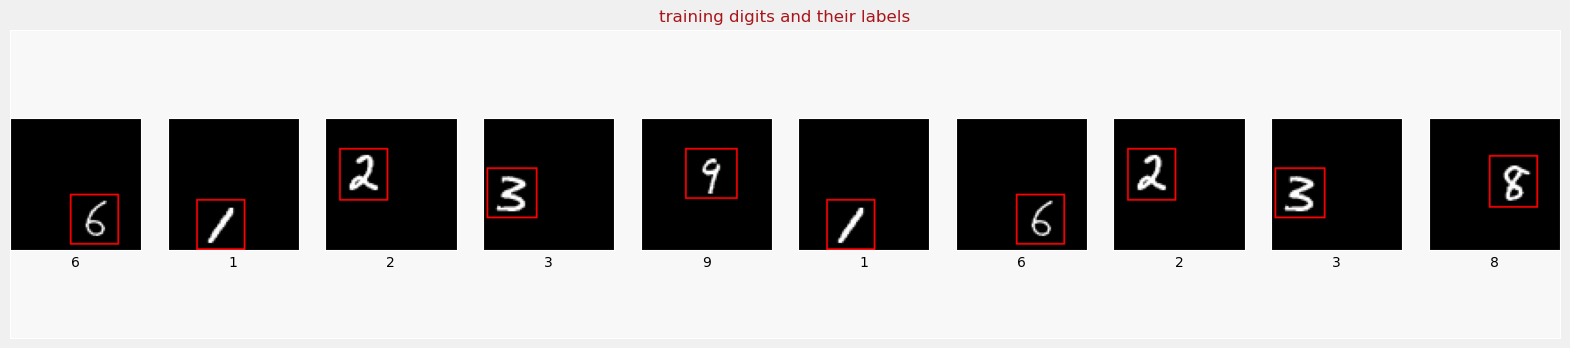

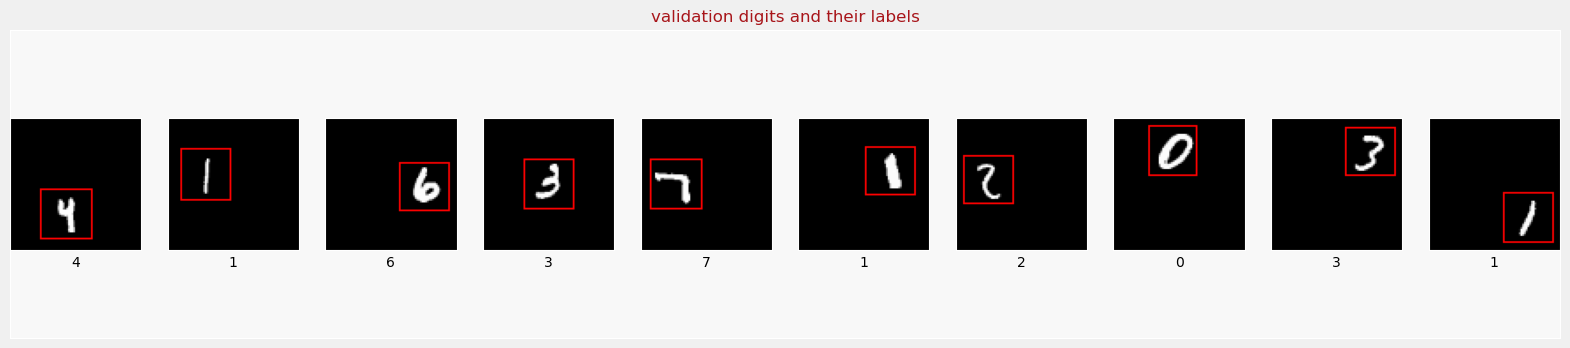

In [9]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, 
                                                                                  validation_dataset, 
                                                                                  10)

display_digits_with_boxes(training_digits, training_labels, training_labels, 
                          np.array([]), training_bboxes, np.array([]), "training digits and their labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, 
                          np.array([]), validation_bboxes, np.array([]), "validation digits and their labels")


## Define the Network

Here, you'll define your custom CNN. 
- `feature_extractor`: these convolutional layers extract the features of the image.
- `classifier`:  This define the output layer that predicts among 10 categories (digits 0 through 9)
- `bounding_box_regression`: This defines the output layer that predicts 4 numeric values, which define the coordinates of the bounding box (xmin, ymin, xmax, ymax)
- `final_model`: This combines the layers for feature extraction, classification and bounding box prediction.  
  - Notice that this is another example of a branching model, because the model splits to produce two kinds of output (a category and set of numbers).  
  - Since you've learned to use the Functional API earlier in the specialization (course 1), you have the flexibility to define this kind of branching model!
- `define_and_compile_model`: choose the optimizer and metrics, then compile the model.

In [10]:
'''
Feature extractor is the CNN that is made up of convolution and pooling layers.
'''
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

'''
dense_layers adds a flatten and dense layer.
This will follow the feature extraction layers
'''
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x


'''
Classifier defines the classification output.
This has a set of fully connected layers and a softmax layer.
'''
def classifier(inputs):
    classification_output = tf.keras.layers.Dense(10, activation='softmax', name = 'classification')(inputs)
    return classification_output


'''
This function defines the regression output for bounding box prediction. 
Note that we have four outputs corresponding to (xmin, ymin, xmax, ymax)
'''
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output


def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    '''
    The model branches here.  
    The dense layer's output gets fed into two branches:
    classification_output and bounding_box_output
    '''
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs=inputs, 
                           outputs=[classification_output, bounding_box_output])

    return model
  

def define_and_compile_model(inputs):
    model = final_model(inputs)
  
    model.compile(optimizer='adam', 
                  loss = {'classification' : 'categorical_crossentropy',
                          'bounding_box' : 'mse'},
                  metrics = {'classification' : 'accuracy',
                             'bounding_box' : 'mse'})
    return model

    
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
    model = define_and_compile_model(inputs)

# print model layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 73, 73, 16)   160         ['input_1[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 36, 16)  0           ['conv2d[0][0]']                 
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   4640        ['average_pooling2d[0][0]']  

### Train and validate the model

Train the model.  
- You can choose the number of epochs depending on the level of performance that you want and the time that you have.
- Each epoch will take just a few seconds if you're using the TPU.

In [11]:
EPOCHS = 45 # 45
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=validation_dataset, 
                    validation_steps=validation_steps, 
                    epochs=EPOCHS)

(loss, classification_loss, bounding_box_loss, 
 classification_accuracy, bounding_box_mse) = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/45


2023-03-21 18:04:58.593729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


930/937 [============================>.] - ETA: 0s - loss: 0.9526 - classification_loss: 0.9386 - bounding_box_loss: 0.0140 - classification_accuracy: 0.6686 - bounding_box_mse: 0.0140

2023-03-21 18:05:06.709397: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-21 18:05:06.709438: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-03-21 18:05:07.660631: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-21 18:05:08.616709: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_

937/937 [==============================] - 14s 10ms/step - loss: 0.9478 - classification_loss: 0.9339 - bounding_box_loss: 0.0139 - classification_accuracy: 0.6702 - bounding_box_mse: 0.0139 - val_loss: 0.2897 - val_classification_loss: 0.2815 - val_bounding_box_loss: 0.0082 - val_classification_accuracy: 0.9151 - val_bounding_box_mse: 0.0082
Epoch 2/45
937/937 [==============================] - 7s 7ms/step - loss: 0.2494 - classification_loss: 0.2439 - bounding_box_loss: 0.0055 - classification_accuracy: 0.9269 - bounding_box_mse: 0.0055 - val_loss: 0.1682 - val_classification_loss: 0.1646 - val_bounding_box_loss: 0.0037 - val_classification_accuracy: 0.9497 - val_bounding_box_mse: 0.0037
Epoch 3/45
937/937 [==============================] - 7s 7ms/step - loss: 0.1797 - classification_loss: 0.1765 - bounding_box_loss: 0.0032 - classification_accuracy: 0.9471 - bounding_box_mse: 0.0032 - val_loss: 0.1711 - val_classification_loss: 0.1683 - val_bounding_box_loss: 0.0028 - val_classifica

Epoch 24/45
937/937 [==============================] - 7s 7ms/step - loss: 0.0380 - classification_loss: 0.0371 - bounding_box_loss: 9.5415e-04 - classification_accuracy: 0.9882 - bounding_box_mse: 9.5415e-04 - val_loss: 0.0372 - val_classification_loss: 0.0362 - val_bounding_box_loss: 9.6743e-04 - val_classification_accuracy: 0.9882 - val_bounding_box_mse: 9.6743e-04
Epoch 25/45
937/937 [==============================] - 7s 7ms/step - loss: 0.0360 - classification_loss: 0.0351 - bounding_box_loss: 9.1077e-04 - classification_accuracy: 0.9891 - bounding_box_mse: 9.1077e-04 - val_loss: 0.0374 - val_classification_loss: 0.0366 - val_bounding_box_loss: 8.1685e-04 - val_classification_accuracy: 0.9872 - val_bounding_box_mse: 8.1685e-04
Epoch 26/45
937/937 [==============================] - 7s 7ms/step - loss: 0.0357 - classification_loss: 0.0348 - bounding_box_loss: 9.0858e-04 - classification_accuracy: 0.9895 - bounding_box_mse: 9.0858e-04 - val_loss: 0.0343 - val_classification_loss: 0.0

1/1 [==============================] - 0s 420ms/step - loss: 0.0265 - classification_loss: 0.0258 - bounding_box_loss: 7.1438e-04 - classification_accuracy: 0.9919 - bounding_box_mse: 7.1438e-04
Validation accuracy:  0.9919000267982483


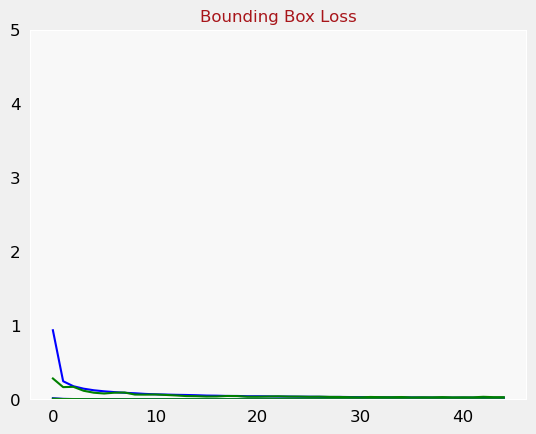

In [12]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")

## Intersection over union

Calculate the I-O-U metric to evaluate the model's performance.

In [13]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

### Visualize predictions
The following code will make predictions and visualize both the classification and the predicted bounding boxes.
- The true bounding box labels will be in green, and the model's predicted bounding boxes are in red.
- The predicted number is shown below the image.

157/157 [==============================] - 1s 4ms/step
Number of predictions where iou > threshold(0.6): 9582
Number of predictions where iou < threshold(0.6): 418


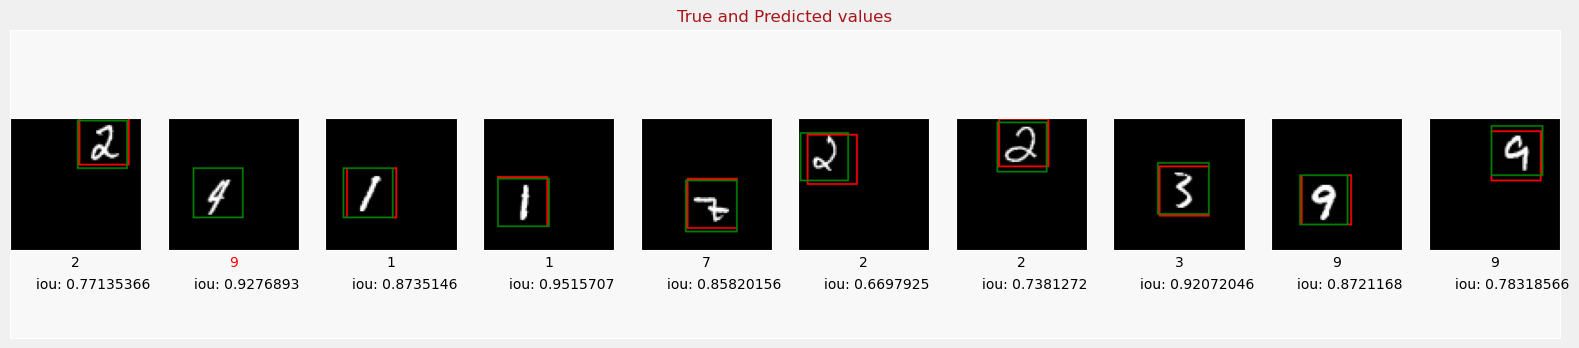

In [14]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")